<a href="https://colab.research.google.com/github/lucaskawazoi/lkk-xview2/blob/master/localization/create_tfrecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
- https://www.tensorflow.org/tutorials/load_data/tfrecord#write_the_tfrecord_file
- https://cloud.google.com/tpu/docs/tutorials/mnist#download_and_convert_the_mnist_data
- /home/lucaskawazoi/development/professional/temp/tpu/models/official/mnist
- /home/lucaskawazoi/development/professional/lkk-xview2/localization

In [1]:
# Import libraries
import os
from pathlib import Path
import tensorflow as tf
print('TF version:', tf.__version__)

TF version: 1.15.0


In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
# Authenticate, config credentials and download data
# ! gcloud auth login
# ! gcloud config set project lkk-project-1
# ! gsutil ls gs://lkk-xview2/xBD/spacenet_gt
# ! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/dataSet .
# ! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/images .
# ! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/grayscale_labels .
# ! ls

In [7]:
# Set folder paths
PATH = Path()
image_folder = PATH / 'images'
semantic_segmentation_folder = PATH / 'grayscale_labels'
train_val_txt_folder = PATH / 'dataSet'
output_folder = PATH / 'tfrecords'
output_folder.mkdir(exist_ok=True)

# List files
images_list = sorted(image_folder.iterdir())
semantic_segmentation_list = sorted(semantic_segmentation_folder.iterdir())

dataset = 'val'
with open(train_val_txt_folder/ '{}.txt'.format(dataset), 'r') as f:
    filenames = [line.strip() for line in f]
print(len(images_list), len(semantic_segmentation_list), dataset, ':', len(filenames))

2283 2283 val : 571


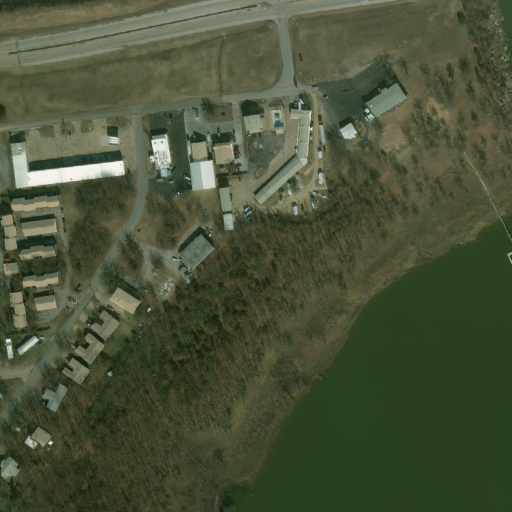

In [20]:
# Take a look at some images image
import random
import cv2
from google.colab.patches import cv2_imshow

img_example = random.choice(images_list)
label_example = semantic_segmentation_folder / img_example.name
image = cv2.imread(str(img_example))
label = cv2.imread(str(label_example))
combined = cv2.addWeighted(image, 0.8, label, 0.2, 0) 
f = 2
combined = cv2.resize(combined, (1024//f, 1024//f))
cv2_imshow(combined)

In [21]:
# Create TF.Example
def image_example(image_path):
  label_path = semantic_segmentation_folder / image_path.name

  # Get filenames
  image_filename = image_path.name.encode('utf-8')
  label_filename = label_path.name.encode('utf-8')
  
  # Open image and label as arrays
  image = cv2.imread(str(image_path))
  label = cv2.imread(str(label_path))
  # print('Type image:', type(image))

  image_string = cv2.imencode('.png', image)[1].tobytes()
  label_string = cv2.imencode('.png', label)[1].tobytes()
  # print('Type image_string:', type(image_string))

  image_shape = image.shape
  # print('Image shape:', image_shape)

  feature = {
      'image_encoded': _bytes_feature(image_string),
      'image_filename': _bytes_feature(image_filename),
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label_encoded': _bytes_feature(label_string),
      'label_filename': _bytes_feature(label_filename),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

image_path = random.choice(images_list)
image_example(image_path)

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 1024
      }
    }
  }
  feature {
    key: "image_encoded"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\004\000\000\000\004\000\010\002\000\000\000\360\177\274\324\000\000 \000IDATx\001<\301Y\317\246\331u\036\346\373^k\357gx\307o\252\252\356\352n\262ER\214$\322\226\225\001\006\034\344\310@\376\203\020;\201\035\333\n\020\300\'\372]9\311AN\014\003A&\331\220\225D\003\007\211\335\244\232\354\352\256\252o|\347\347y\366^k\345\375JI\256\213\177\374\307\177t<\236\246RA\342\031E\225\244\273\233;\"H\212\010\200\370;\000\310\0107w\004DT\204\305\374\361\351\251\353\373\371r.*\207\343!e\211pD\220\341V\206\323PkY\314\033\3013\001TDE\335\034\014\n\343\314#\020B\206\005\"\000\244\224\016\207\361\375\373\307\373\207\355\315\365\345\365\345ex\200hR\002\340\037\220\014w\217 \331\

In [0]:
# Set variables
import math
_NUM_SHARDS = 4
dataset = 'train'

In [0]:
with open(train_val_txt_folder/ '{}.txt'.format(dataset), 'r') as f:
    filenames = [image_folder / line.strip() for line in f]
num_images = len(filenames)
num_per_shard = int(math.ceil(num_images / _NUM_SHARDS))

In [41]:
len(filenames)

1712

In [42]:
for shard_id in range(_NUM_SHARDS):
  output_filename = output_folder / '{}-{:05d}-of-{:05d}.tfrecord'.format(dataset, shard_id, _NUM_SHARDS)
  with tf.python_io.TFRecordWriter(str(output_filename)) as tfrecord_writer:
    start_idx = shard_id * num_per_shard
    end_idx = min((shard_id + 1) * num_per_shard, num_images)
    print('\r>> Converting images {}-{} (of {}). shard {}'.format(start_idx, end_idx, len(filenames), shard_id))
    for i in range(start_idx, end_idx):
      # Read the image.
      image_path = filenames[i]
      tf_example = image_example(image_path)
      tfrecord_writer.write(tf_example.SerializeToString())

>> Converting images from 0 to 428 of 1712 shard 0
>> Converting images from 428 to 856 of 1712 shard 1
>> Converting images from 856 to 1284 of 1712 shard 2
>> Converting images from 1284 to 1712 of 1712 shard 3


In [0]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'teste.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [0]:
# How to decode / read
# cv2.imdecode(np.fromstring(image_string, dtype=np.uint8), 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


array([[[ 51,  65,  61],
        [ 66,  83,  81],
        [ 82, 104, 106],
        ...,
        [ 72,  93,  97],
        [ 63,  84,  87],
        [ 66,  87,  91]],

       [[ 37,  48,  45],
        [ 64,  81,  80],
        [ 73,  93,  94],
        ...,
        [ 72,  94, 100],
        [ 63,  84,  88],
        [ 64,  85,  89]],

       [[ 40,  50,  46],
        [ 57,  72,  70],
        [ 64,  82,  81],
        ...,
        [ 71,  93,  99],
        [ 68,  90,  96],
        [ 70,  92,  98]],

       ...,

       [[ 73, 100, 113],
        [ 72,  98, 111],
        [ 73,  99, 112],
        ...,
        [ 49,  59,  52],
        [ 55,  64,  55],
        [ 55,  63,  54]],

       [[ 73, 100, 113],
        [ 72,  98, 111],
        [ 73,  99, 112],
        ...,
        [ 55,  64,  57],
        [ 63,  70,  62],
        [ 59,  66,  57]],

       [[ 72,  99, 112],
        [ 70,  96, 108],
        [ 72,  97, 109],
        ...,
        [ 57,  66,  58],
        [ 66,  73,  65],
        [ 59,  66,  57]]